# Predicting NHL Clutch Goalscorers

This project applies machine learning techniques to identify and predict NHL forwards who excel in “clutch” situations (close, tied, and overtime games). The goal is not only to measure clutch performance but also to model expected clutch scoring given a player’s underlying metrics and understand the reasoning behind the predictions.

The final model has been deployed to a [Streamlit Dashboard](https://shak789-nhl-clutch-goalscorers-app-dpjtq2.streamlit.app/) that is updated at 9:00 a.m. EST daily.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from sklearn.utils import resample

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

import shap
import joblib

### NHL API

In [5]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009        Zdeno Chara            D           72       12        0   
1      8466138       Joe Thornton            C           34        5        0   
2      8469455       Jason Spezza            C           71       13        0   
3      8470281       Duncan Keith            D           64       20        0   
4      8470595         Eric Staal            C           72       15        0   
...        ...                ...          ...          ...      ...      ...   
1250   8484314       Jiri Smejkal            L           20        1        0   
1251   8484321  Nikolas Matinpalo            D            4        0        0   
1252   8484325    Waltteri Merela            C           19        0        0   
1253   8484326        Patrik Koch            D   

### Cleaning the NHL API Data
-  Only forwards are included since defensemen score at different rates. 
-  Players must have appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.

In [7]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D')]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_60'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

### Scraping Data from Natural Stat Trick

In [9]:
start_season = "20212022"
end_season = "20232024"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [10]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    if name == "goals_down_one":
         df.rename(columns={'TOI': 'TOI_Down_One'}, inplace=True)
    elif  name == "tied":
        df.rename(columns={'TOI': 'TOI_Tied'}, inplace=True)
    dataframes[name] = df
    time.sleep(3)

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

### Cleaning Data from Natural Stat Trick
Similar to the NHL API data, only players who have played at least 60 games are included. The dataframes have already been filtered for forwards through the URLs.


In [12]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['TOI_Down_One', 'Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['TOI_Tied', 'Player', 'goals_when_tied']]
total_df = total_df[['TOI', 'Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF', 'SH%']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat['clutch_goals'] = merged_natural_stat['goals_down_by_one'] + merged_natural_stat['goals_when_tied']
merged_natural_stat['TOI_Clutch'] = merged_natural_stat['TOI_Down_One'] + merged_natural_stat['TOI_Tied']
merged_natural_stat = merged_natural_stat.loc[(merged_natural_stat['TOI_Clutch'] >= 450) & (merged_natural_stat['total_goals'] >= 30)]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}
merged_natural_stat.rename(columns = rename_columns, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [14]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak", "Zack Bolduc", "Frederic Gaudreau"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak", "Zachary Bolduc", "Freddy Gaudreau"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [16]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals = merged_clutch_goals.dropna()

### Changing Columns
Compute per game stats to accurately compare players.

In [18]:
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied','shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_60_string = f"{column}_per_60"
    merged_clutch_goals[per_60_string] = merged_clutch_goals[column] / merged_clutch_goals['TOI_Clutch'] * 60

### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from regular 5v5.

In [20]:
merged_clutch_goals['clutch_score'] = (
    merged_clutch_goals['clutch_goals'] / merged_clutch_goals['TOI_Clutch'] * 60
)

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [22]:
merged_clutch_goals['clutch_score'] *= 10
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
174,Gabriel Landeskog,21.58,1.0
309,David Pastrnak,20.56,2.0
426,Auston Matthews,20.45,3.0
205,Filip Forsberg,18.30,4.0
405,Kirill Kaprizov,17.79,5.0
293,Leon Draisaitl,16.54,6.0
463,Tage Thompson,16.39,7.0
66,Steven Stamkos,16.34,8.0
807,Andrei Kuzmenko,16.04,9.0
536,Josh Norris,15.96,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


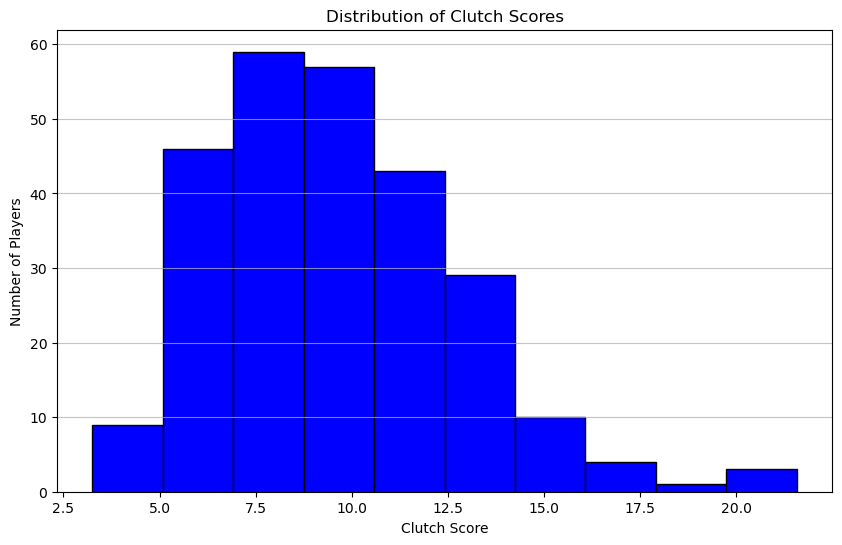

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [26]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [28]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    221
1     40
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was noidealea.


### Starting with XGBoost

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [31]:
x_var = ['iSCF_per_60', 'assists_per_60', 'rebounds_created_per_60', 'off_zone_starts_per_60', 'SH%']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [33]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.045414
score_time        0.010158
test_accuracy     0.889316
test_precision    0.731667
test_recall       0.575000
test_f1           0.578810
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation
Note: The high imbalance in the dataset means that stratified cross-validation may not be able to create balanced splits, leading to the error message.


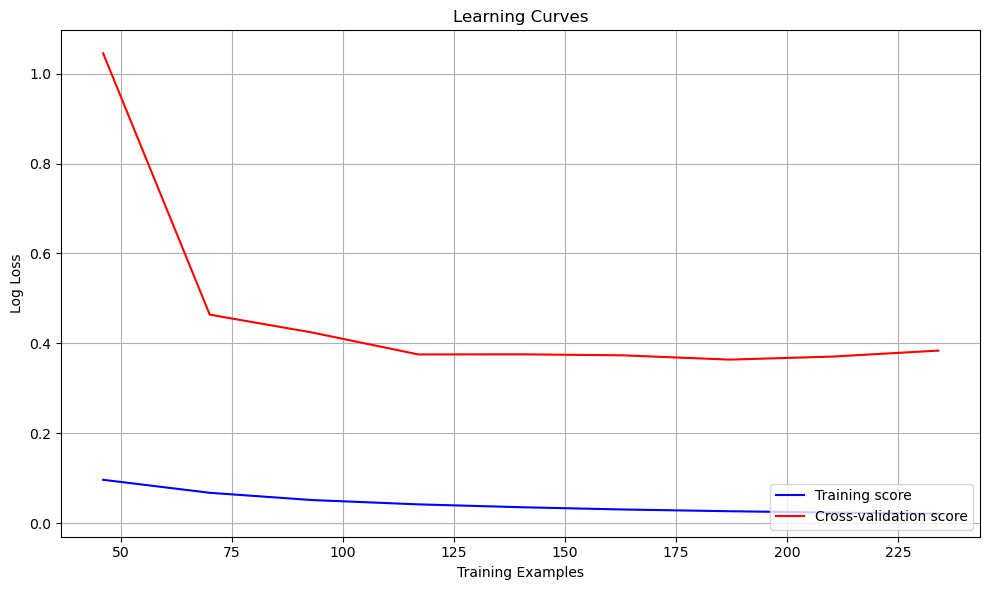

In [35]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model better generalization.


In [37]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


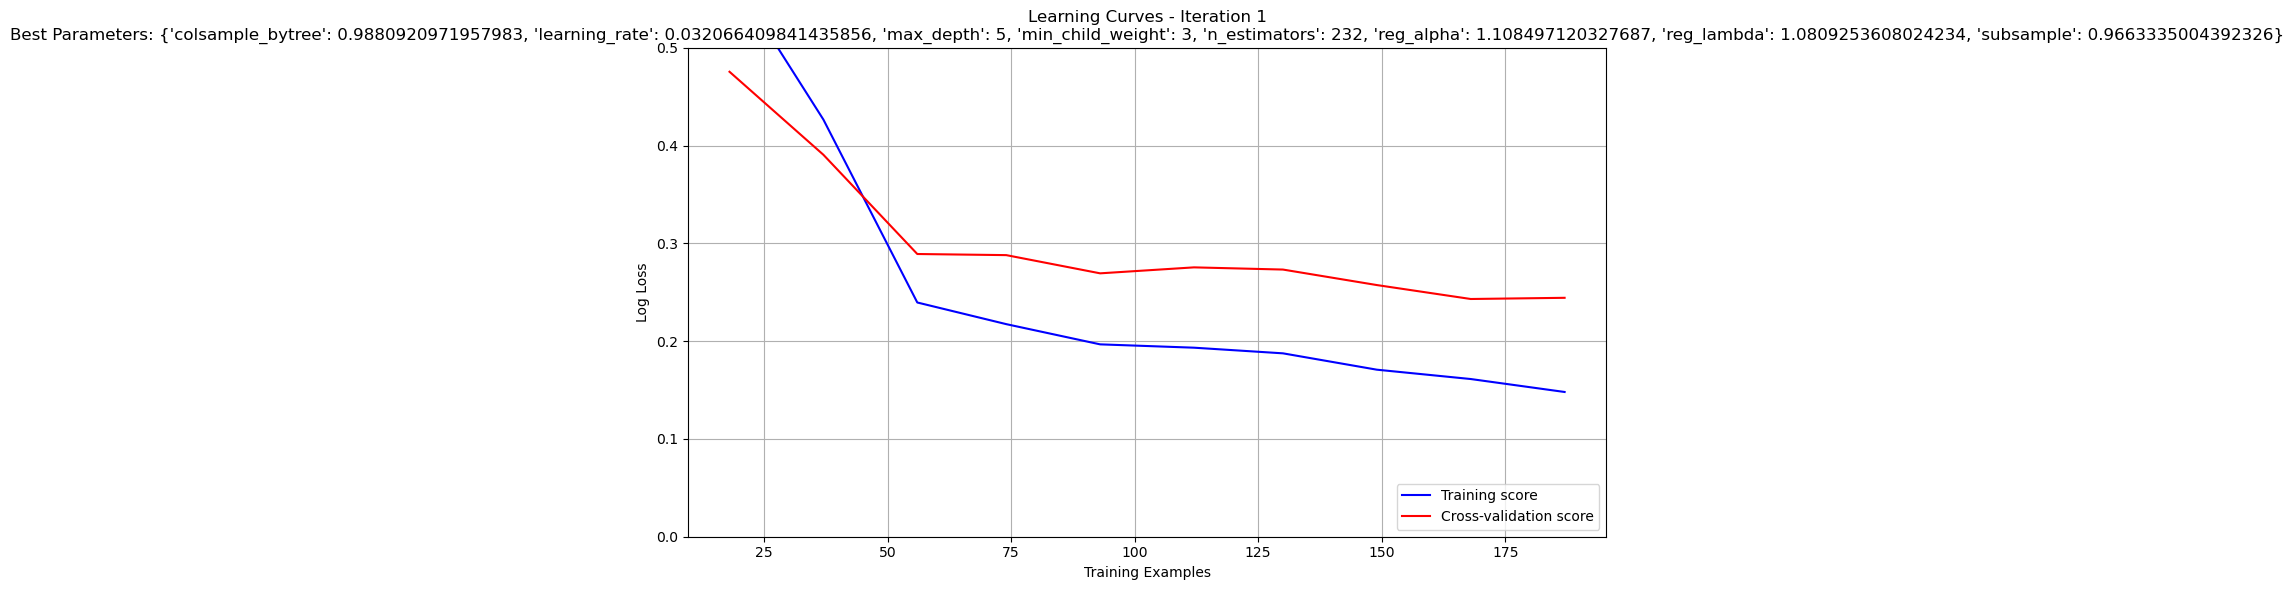


Precision Score:  0.75
Recall Score:  0.375

Correct Classfications
              Player  clutch_score_rank  Actual  Predicted
365    Sebastian Aho               20.0       1          1
377      Roope Hintz               11.0       1          1
807  Andrei Kuzmenko                9.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
398  Artemi Panarin               39.0       1          0
274       Bo Horvat               29.0       1          0
382   Daniel Sprong               34.0       1          0
577   Brady Tkachuk               36.0       1          0
358     Jack Eichel               35.0       1          0



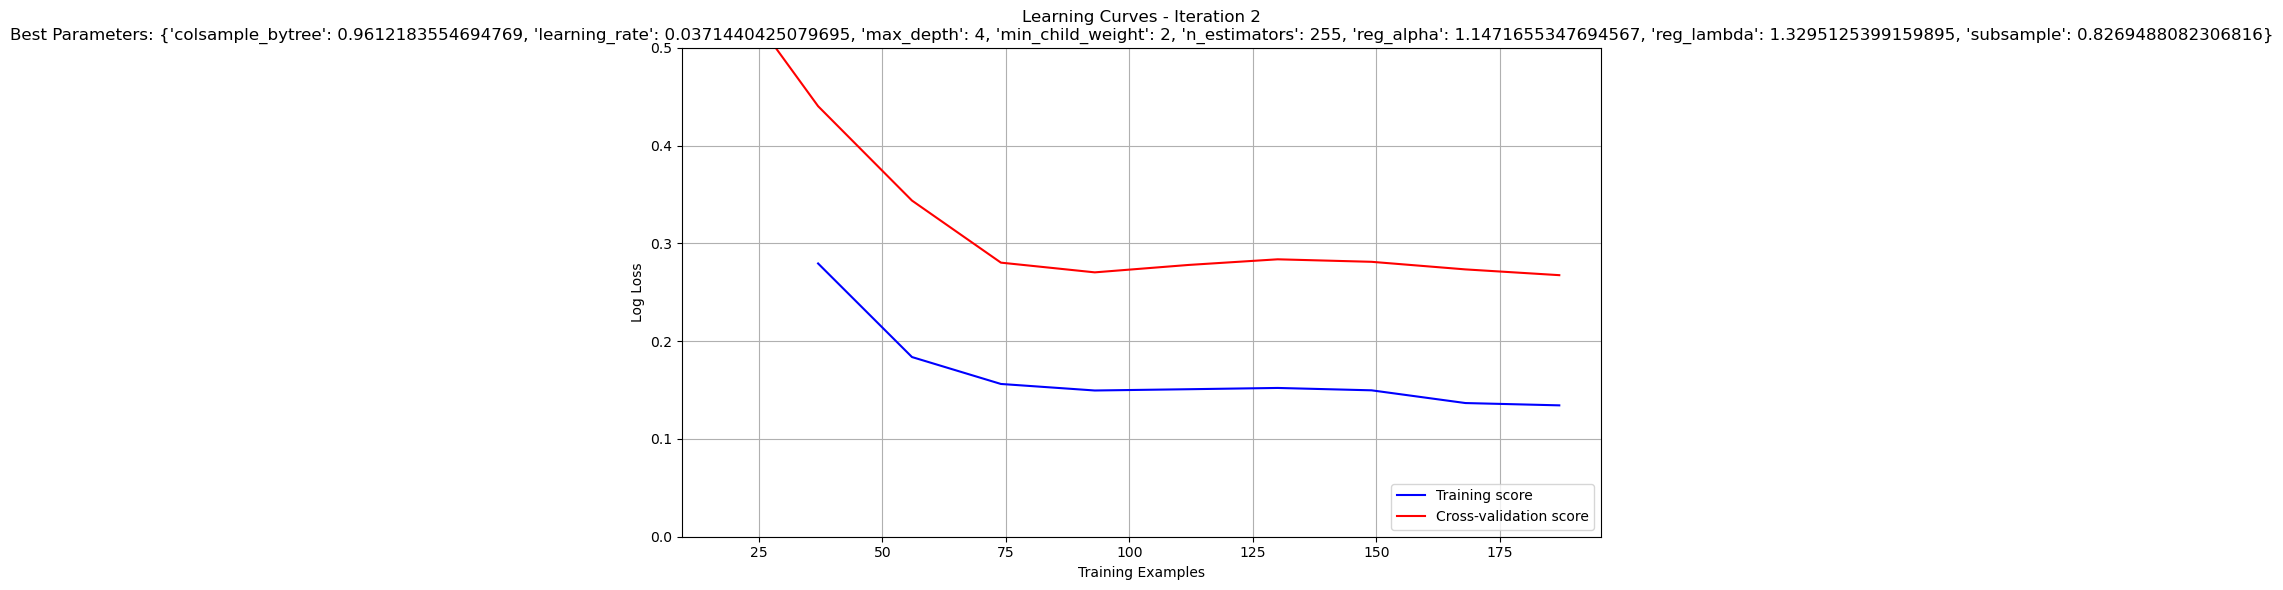


Precision Score:  0.5
Recall Score:  0.25

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
249  Carter Verhaeghe               40.0       1          1
519   Gabriel Vilardi               13.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
89     Evander Kane               25.0       1          0
310    Adrian Kempe               26.0       1          0
577   Brady Tkachuk               36.0       1          0
125    Jeff Skinner               28.0       1          0
293  Leon Draisaitl                6.0       1          0
382   Daniel Sprong               34.0       1          0



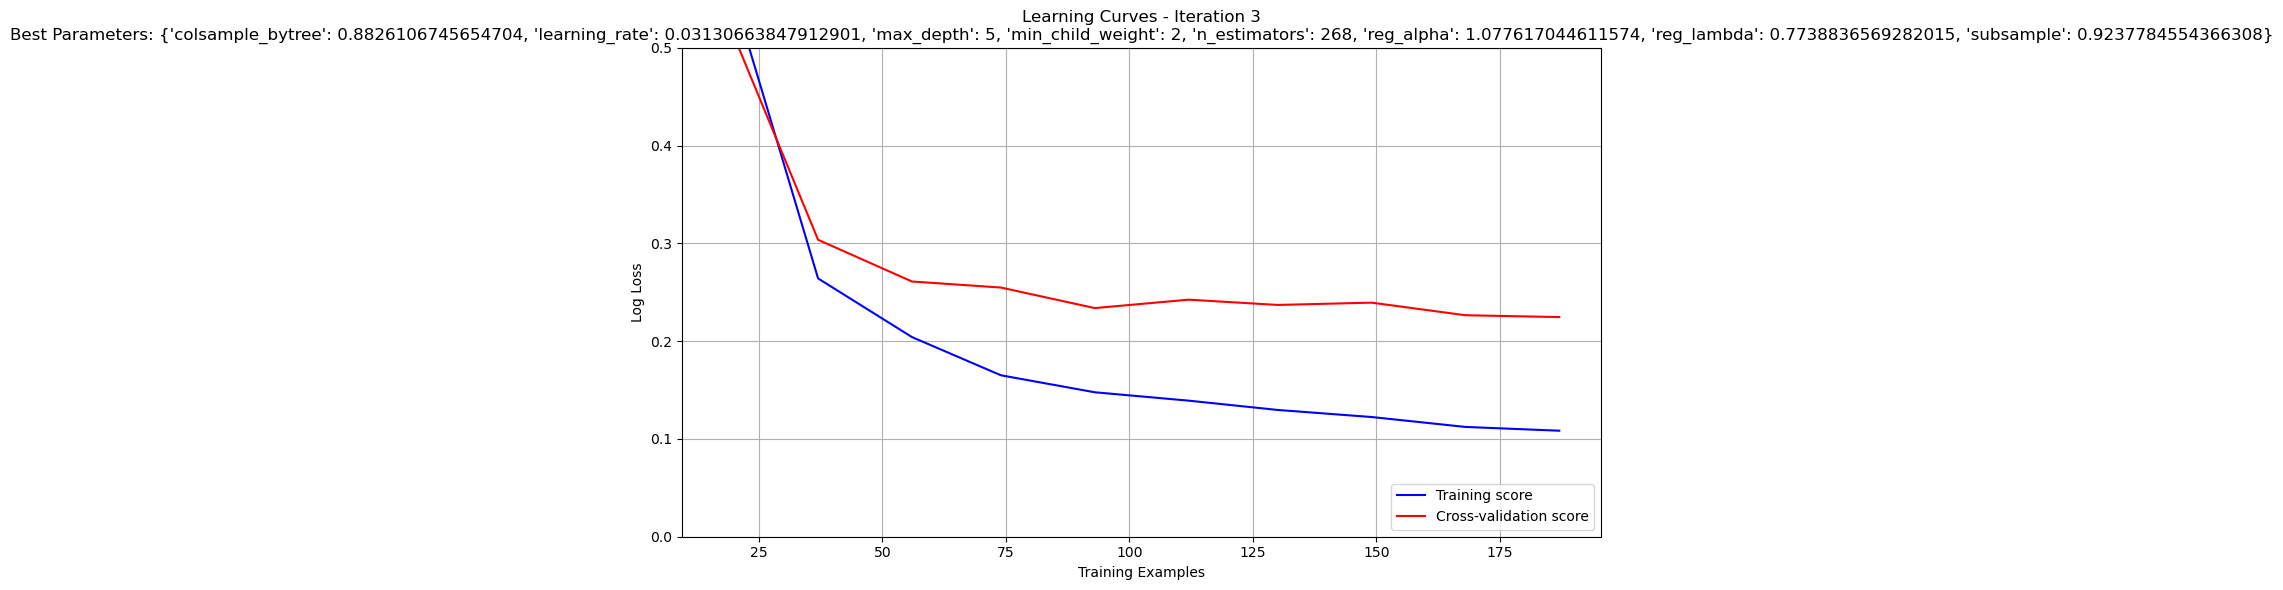


Precision Score:  0.625
Recall Score:  0.625

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
426   Auston Matthews                3.0       1          1
362    Mikko Rantanen               21.0       1          1
296  William Nylander               17.0       1          1
125      Jeff Skinner               28.0       1          1
377       Roope Hintz               11.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
177  Mika Zibanejad               24.0       1          0
358     Jack Eichel               35.0       1          0
302    Dylan Larkin               23.0       1          0



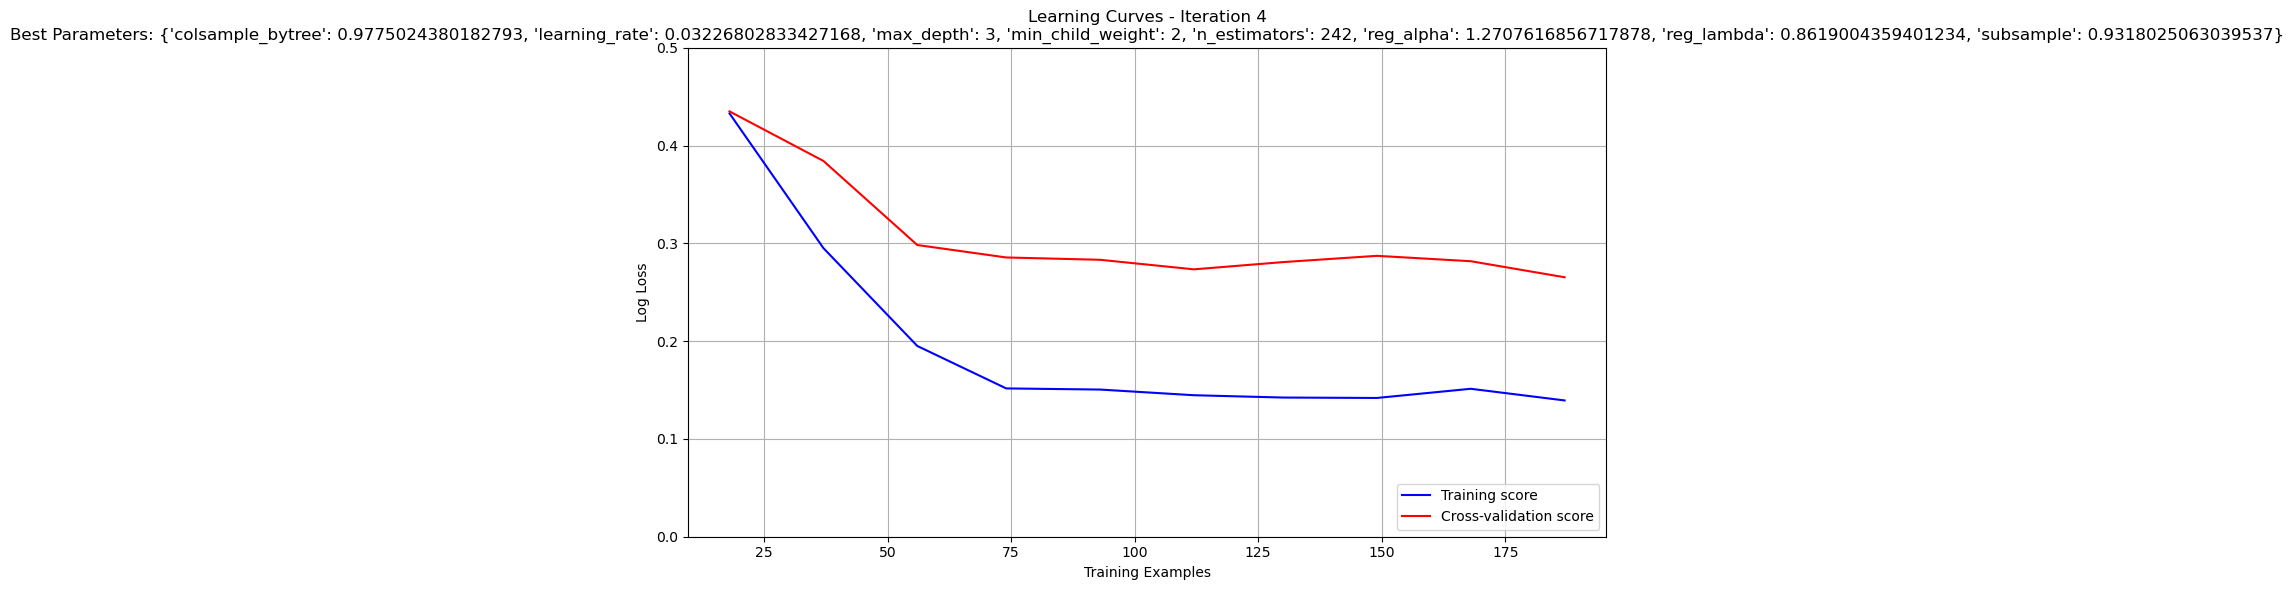


Precision Score:  0.4
Recall Score:  0.25

Correct Classfications
             Player  clutch_score_rank  Actual  Predicted
377     Roope Hintz               11.0       1          1
205  Filip Forsberg                4.0       1          1

Missed Cltuch Players
                    Player  clutch_score_rank  Actual  Predicted
361             Timo Meier               32.0       1          0
87            John Tavares               37.0       1          0
354            Kyle Connor               27.0       1          0
308           Jared McCann               33.0       1          0
189  Jonathan Marchessault               31.0       1          0
519        Gabriel Vilardi               13.0       1          0



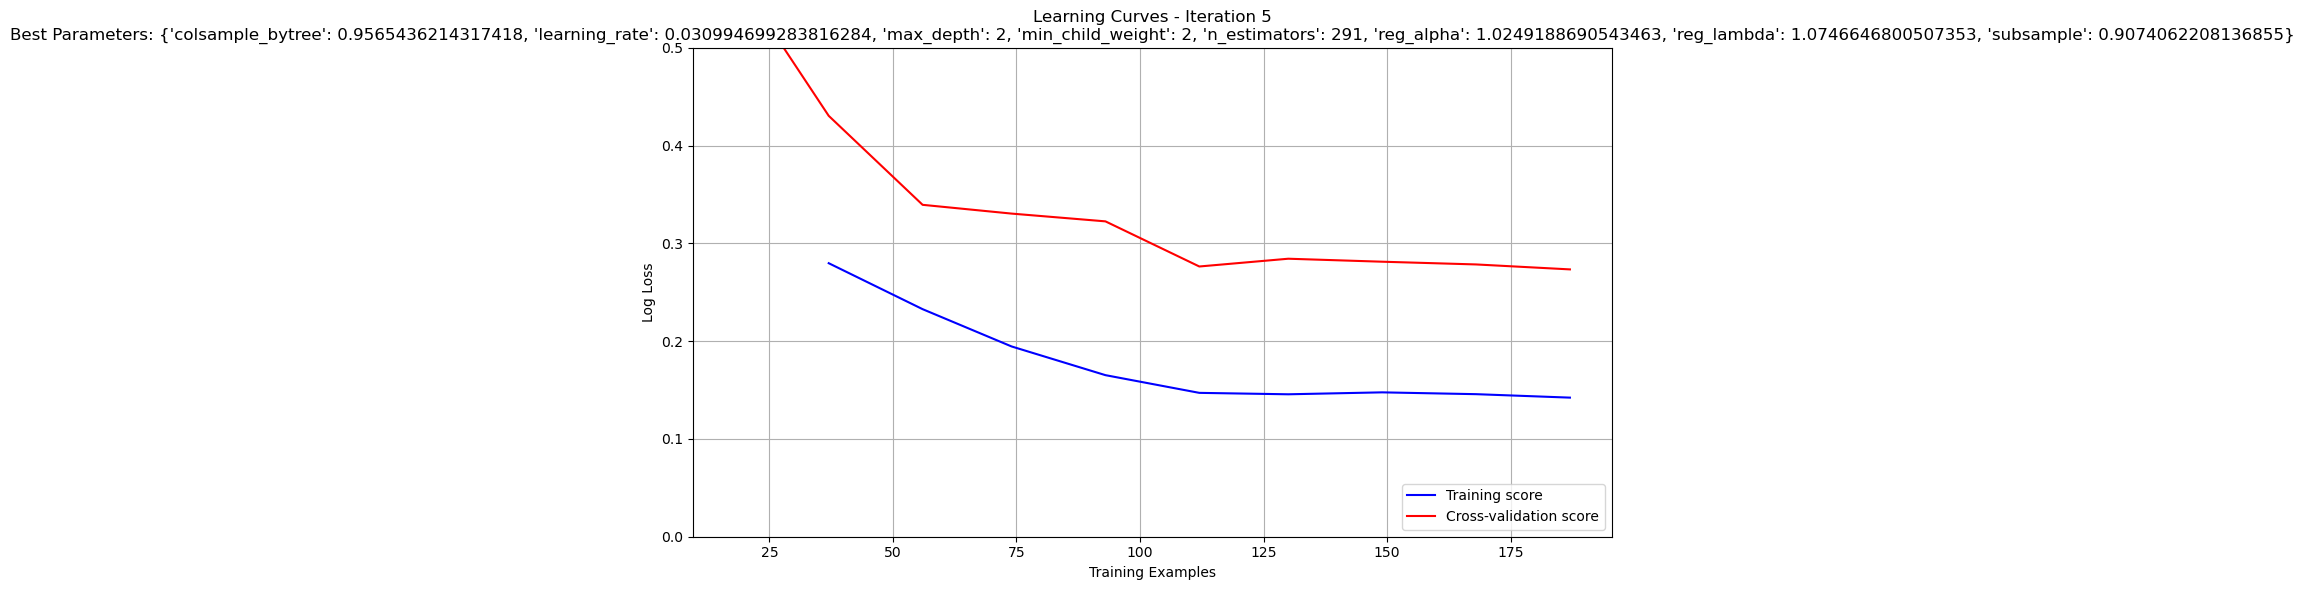


Precision Score:  0.6666666666666666
Recall Score:  0.75

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
249  Carter Verhaeghe               40.0       1          1
117      Brock Nelson               19.0       1          1
577     Brady Tkachuk               36.0       1          1
320     Brayden Point               12.0       1          1
365     Sebastian Aho               20.0       1          1
269  Nathan MacKinnon               30.0       1          1

Missed Cltuch Players
                    Player  clutch_score_rank  Actual  Predicted
189  Jonathan Marchessault               31.0       1          0
310           Adrian Kempe               26.0       1          0

Average Precision: 0.5883333333333333
Average Recall: 0.45
Average F1 Score: 0.4943815987933635


In [40]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a moderate/strong positive correlation with clutch score (with some outliers distoring the r values), which indicates that a linear regression model is suitable.


In [43]:
merged_clutch_goals = merged_clutch_goals.fillna(0)

In [44]:
x_var = ['iSCF_per_60', 'assists_per_60', 'rebounds_created_per_60', 'SH%']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

iSCF_per_60                0.677314
assists_per_60             0.436079
rebounds_created_per_60    0.488786
SH%                        0.558511
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

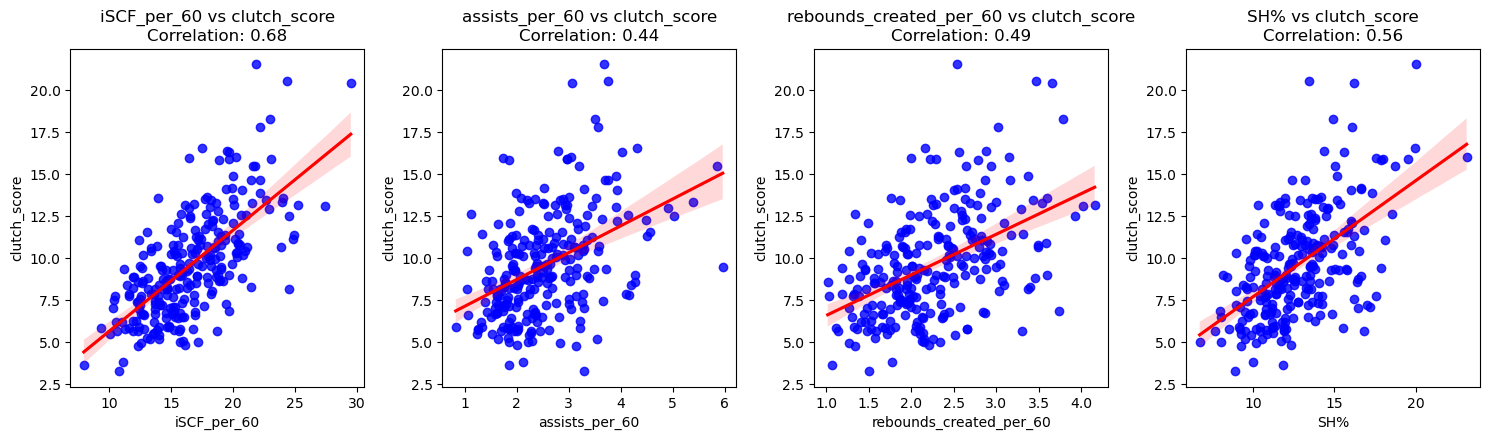

In [46]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 4, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Ridge Regression
Ridge regression helps to reduce the effect of multicollinearity on coefficients by reducing correlated coefficients towards 0. This improves their stability compared to standard OLS. Unlike lasso regression, it does not set coefficients to exactly 0. Ridge regression also ensures there is less overfitting. Time Series Cross-Validation is used to avoid leaking future information during traning due to the temporal nature of the data (2021-2024 seasons).

The model shows good performance because it has a low MSE of approximately 1 and R² of approximately 63%. In future sections, the outliers are evaluated to determine the model's limitations which are not obvious with the MSE and R².

In [48]:
from sklearn.model_selection import TimeSeriesSplit

x_var = ['iSCF_per_60', 'assists_per_60', 'rebounds_created_per_60', 'SH%']

X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-3, 3, 20)
ridge_cv = RidgeCV(alphas=alphas, cv=tscv)
ridge_cv.fit(train_x, train_y)
y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  3.237747795914239
RMSE:  1.7993742789965181
Median Error:  0.8838201697442827
R²:  0.6315385756506229
Adjusted R²:  0.6242782520181229


### Multicollinearity
The extreme VIF values indicate strong correlation between the features. The multicollinearity is expected because offensive statistics are closely correlated. 

In [50]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_adjusted.columns

vif_data["VIF"] = [variance_inflation_factor(X_adjusted.values, i)
                          for i in range(len(X_adjusted.columns))]
print(vif_data)

                   feature        VIF
0              iSCF_per_60  72.793742
1           assists_per_60  11.734312
2  rebounds_created_per_60  41.184707
3                      SH%  17.733869


### Learning Curves

The learning curves do not show significant overfitting. After approximately 200 samples, both training and validation curves converge to an MSE of less than
2 
Thus, Ridge Regression is the correct choice for generalizing the training dat.


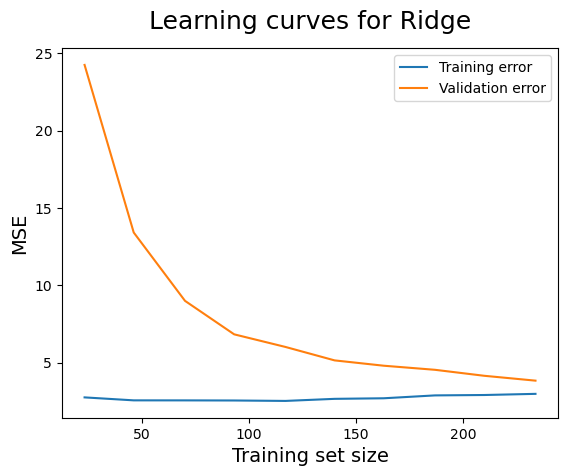

In [52]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

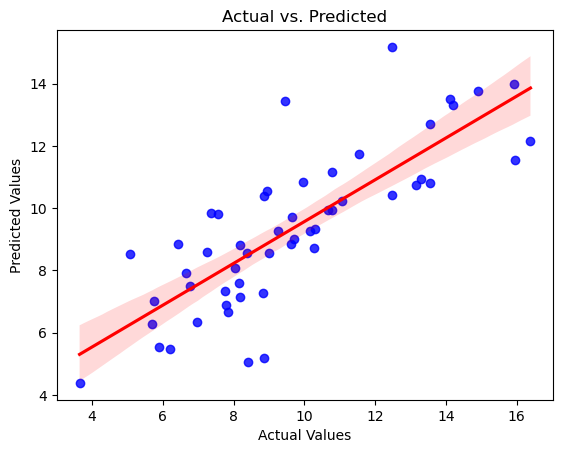

In [54]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

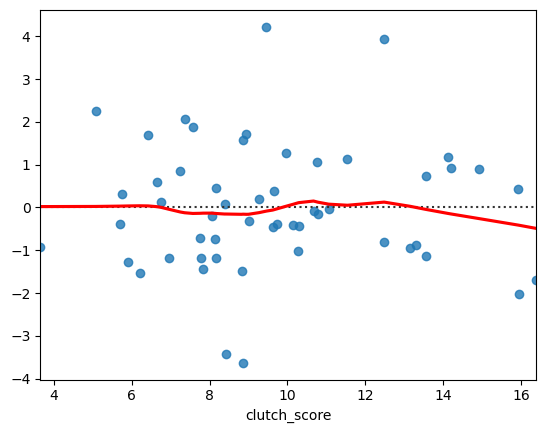

In [56]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

As shown below, the model tends to underestimate the performance of several elite players (e.g., Connor McDavid) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations. These points also have extreme feature values (e.g. iSCF, SH%, assists) which give them high leverage.

Conversely, the model overestimates the performance of other elite players (e.g., Matthew Tkachuk), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 16 influential points.
Outliers based on Cook's Distance:
                Player  Actual  Predicted  Cook's Distance
174  Gabriel Landeskog   21.58  16.777200         0.067357
309     David Pastrnak   20.56  14.558190         0.061521
426    Auston Matthews   20.45  18.226475         0.024135
205     Filip Forsberg   18.30  14.832127         0.027389
807    Andrei Kuzmenko   16.04  17.878782         0.024551
536        Josh Norris   15.96  11.877826         0.030104
177     Mika Zibanejad   13.59   9.135659         0.019270
423    Matthew Tkachuk   12.49  14.868216         0.021976
126         Zach Hyman   11.40  14.993065         0.030409
246      Jake Guentzel   10.67  14.521406         0.022552
57        Patrick Kane   10.39   6.528995         0.030732
172    Nikita Kucherov    9.46  12.911466         0.068126
119        Kevin Hayes    8.86   5.016149         0.035143
294        Sam Bennett    8.16  12.294277         0.037571
331      Dakota Joshua    7.08  11.464056      

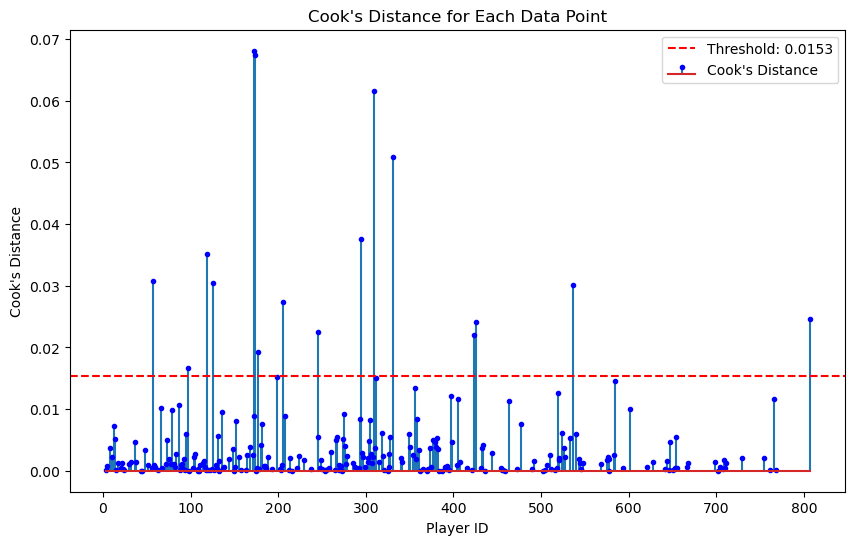

In [58]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


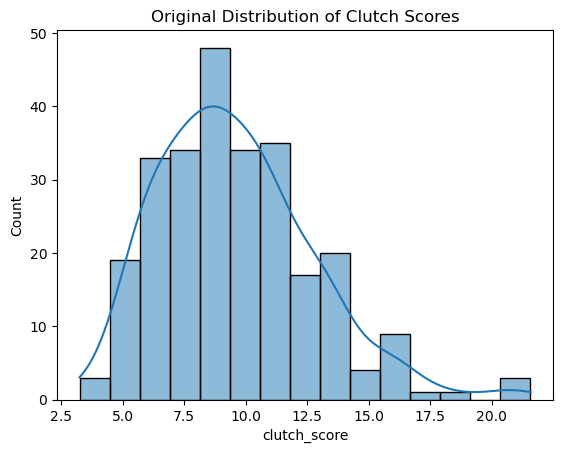

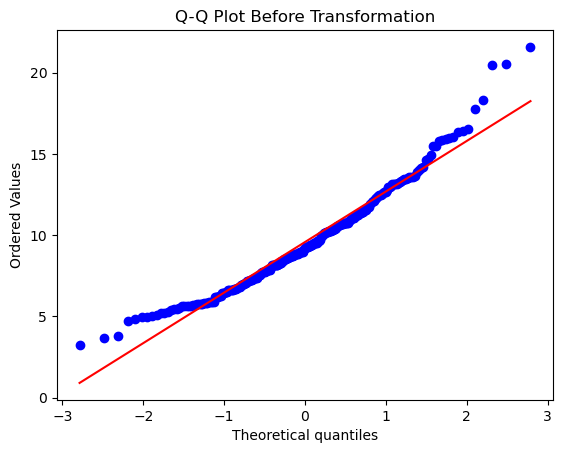

In [60]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Evaluation after Log Tranformation
The model still retains a R² of 62% after the log transformation.

In [62]:
epsilon = np.abs(X_scaled.min()) + 1
X_shifted = X_scaled + epsilon
y_log = np.log(y + 1)
X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log,
    y_log,
    test_size=0.2,
    random_state=200
)

alphas = np.logspace(-3, 3, 20)
ridge_cv_log = RidgeCV(alphas=alphas, cv=5)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  0.03419315894252674
RMSE:  0.18491392306293958
Median Error:  0.11437906026372113
R²:  0.6318952007179615
Adjusted R²:  0.6246419041803843


There are 12 influential points.
Outliers based on Cook's Distance:
               Player    Actual  Predicted  Cook's Distance
309    David Pastrnak  3.070840   2.729843         0.017405
536       Josh Norris  2.830858   2.519462         0.017125
57       Patrick Kane  2.432736   2.012412         0.056789
172   Nikita Kucherov  2.347558   2.612926         0.022668
119       Kevin Hayes  2.288486   1.818782         0.081919
199    Scott Laughton  2.241773   1.845237         0.032968
182        Joel Armia  2.217027   1.932651         0.017318
79       Mike Hoffman  2.142416   1.834154         0.030035
331     Dakota Joshua  2.089392   2.495288         0.040957
356       Pavel Zacha  2.016235   2.317525         0.025580
576  Philipp Kurashev  1.568616   1.861121         0.016582
131   Mikael Granlund  1.446919   1.765473         0.038886


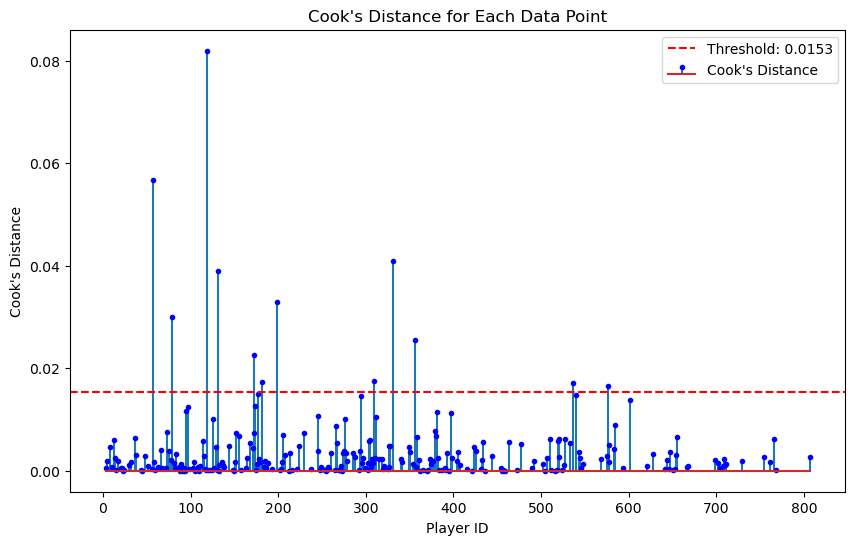

In [63]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_with_intercept)

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index,'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Final Scatter Plot from Training

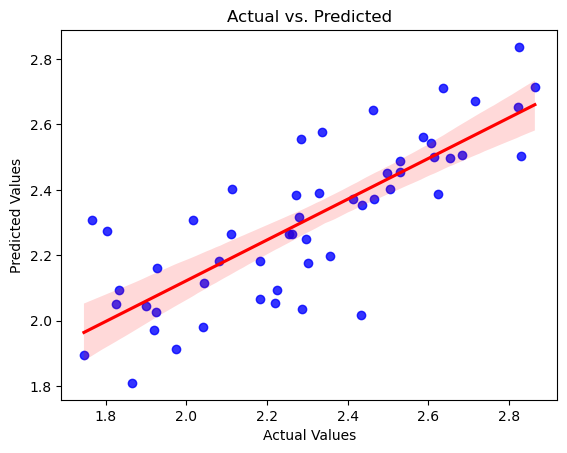

In [65]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2024-2025 season to the current 2025-2026 season).

In [67]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_loaded = joblib.load('ridge_cv_model.pkl')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(epsilon, 'epsilon.pkl')

['epsilon.pkl']

In [68]:
all_seasons = []

for season in range(2024, 2026):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'goals': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean',
            'teamAbbrevs': 'last'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2024-2025
Successfully fetched data for season 2025-2026
      playerId  skaterFullName positionCode  gamesPlayed  goals  assists  \
0      8470600      Ryan Suter            D           82      2       13   
1      8470613     Brent Burns            D          120     11       37   
2      8470621     Corey Perry            R          113     27       20   
3      8471214   Alex Ovechkin            L          105     59       48   
4      8471215   Evgeni Malkin            C           94     24       55   
...        ...             ...          ...          ...    ...      ...   
1005   8485483  Karsen Dorwart            L            5      0        0   
1006   8485493   David Tomasek            R           22      3        2   
1007   8485511    Quinn Hutson            R            5      1        0   
1008   8485512       Tim Washe            C            2      0        0   
1009   8485702    Max Shabanov            R           27      4       

In [69]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D')]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_60'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

In [70]:
start_season = "20242025"
end_season = "20252026"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [71]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    if name == "goals_down_one":
         df.rename(columns={'TOI': 'TOI_Down_One'}, inplace=True)
    elif  name == "tied":
        df.rename(columns={'TOI': 'TOI_Tied'}, inplace=True)
    dataframes[name] = df
    time.sleep(3)

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

In [72]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['TOI_Down_One', 'Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['TOI_Tied', 'Player', 'goals_when_tied']]
total_df = total_df[['TOI', 'Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF', 'SH%']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat['clutch_goals'] = merged_natural_stat['goals_down_by_one'] + merged_natural_stat['goals_when_tied']
merged_natural_stat['TOI_Clutch'] = merged_natural_stat['TOI_Down_One'] + merged_natural_stat['TOI_Tied']
merged_natural_stat = merged_natural_stat.loc[(merged_natural_stat['TOI_Clutch'] >= 175) & (merged_natural_stat['total_goals'] >= 10)]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}
merged_natural_stat.rename(columns = rename_columns, inplace=True)

In [73]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", "Zack Bolduc", "Frederic Gaudreau"] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini", "Zachary Bolduc", "Freddy Gaudreau" ]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [74]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)
merged_clutch_goals_prediction = merged_clutch_goals_prediction.dropna()

In [75]:
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied','shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_60_string = f"{column}_per_60"
    merged_clutch_goals_prediction[per_60_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['TOI_Clutch'] * 60

In [76]:
merged_clutch_goals_prediction['clutch_score'] = (
    merged_clutch_goals_prediction['clutch_goals'] / merged_clutch_goals_prediction['TOI_Clutch'] * 60
)

In [77]:
merged_clutch_goals_prediction['clutch_score'] *= 10
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
177,Leon Draisaitl,18.51,1.0
274,Alex DeBrincat,18.47,2.0
321,Morgan Geekie,17.91,3.0
341,Josh Norris,17.48,4.0
520,Dylan Guenther,17.37,5.0
258,Adam Gaudette,17.17,6.0
295,Tage Thompson,17.11,7.0
112,Tom Wilson,17.03,8.0
32,John Tavares,16.95,9.0
390,Linus Karlsson,16.72,10.0


In [78]:
x_var = ['iSCF_per_60', 'assists_per_60', 'rebounds_created_per_60', 'SH%']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

scaler = joblib.load('scaler.pkl')
epsilon = joblib.load('epsilon.pkl')

X_scaled = scaler.transform(X_adjusted) 
X_scaled = np.nan_to_num(X_scaled, nan=0)

X_shifted = X_scaled + epsilon
X_log = np.log(X_shifted)

y_log = np.log(y + 1)
y_pred = ridge_cv_loaded.predict(X_log)

### Evaluating the Model after Testing
The R² of approximately 56% indicates the model explains 56% of variance in clutch performance. While this is lower than the 63% R² in training, it is reasonable since it is much harder to predict the scoring efficiency of players in high-pressure situations with inherent randomness.

In [80]:
r2 = r2_score(y_log, y_pred)
rmse = np.sqrt(mean_squared_error(y_log, y_pred))
mae = mean_absolute_error(y_log, y_pred)

print(f"Test Set Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Test Set Performance:
R²: 0.5619
RMSE: 0.2295
MAE: 0.1697


In [81]:
y_pred = ridge_cv_loaded.predict(X_log)
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 

merged_clutch_goals_prediction['actual_clutch_score_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['actual_clutch_score_adjusted'] = merged_clutch_goals_prediction['actual_clutch_score_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

### Prediction Intervals
95% bootstrapping prediction intervals were generated for each player. If actual clutch scores fall outside the intervals, this indicates that clutch performance is significantly different from expectations.

In [83]:
n_boot = 1000
alpha = ridge_cv_loaded.alpha_

boot_preds = np.zeros((n_boot, len(X_log)))  

for i in range(n_boot):
    idx = np.random.choice(len(X_log), size=len(X_log), replace=True)

    X_res = X_log[idx]
    y_res = y_log.iloc[idx]

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_res, y_res)

    preds = ridge.predict(X_log)

    residuals = y_log - ridge_cv_loaded.predict(X_log)
    noise = np.random.choice(residuals, size=len(X_log), replace=True)

    boot_preds[i] = preds + noise

lower_log = np.percentile(boot_preds, 2.5, axis=0)
upper_log = np.percentile(boot_preds, 97.5, axis=0)

merged_clutch_goals_prediction['lower_bound_log'] = (lower_log * 10).round(2)
merged_clutch_goals_prediction['upper_bound_log'] = (upper_log * 10).round(2)

merged_clutch_goals_prediction['Significantly_Clutch'] = np.where(
    (merged_clutch_goals_prediction['actual_clutch_score_adjusted'] >= merged_clutch_goals_prediction['lower_bound_log']) &
    (merged_clutch_goals_prediction['actual_clutch_score_adjusted'] <= merged_clutch_goals_prediction['upper_bound_log']),
    'Inside Range',
    'Outside Range'
)

### Shap Values

SHAP values were calculated to explain which features most influenced each player's prediction. This is useful for the dashboard since users can understand how clutch scores are predicted.

Due to the extremely high VIF values, multicollinearity may still be present even when using ridge regression. Therefore, SHAP is used with **feature_perturbation = "correlation_dependent"**. This accounts for correlations between the features when determining their contributions. Therefore, SHAP values will better reflect the true conditional contribution of each feature, rather than being distorted by multicollinearity.

The SHAP plot indicates that SH% is the dominant feature since a higher shooting percentage naturally leads to increased clutch goalscoring. The remaining features show similar SHAP magnitudes which suggests that the features are stable, improving the reliability of the interpretation.

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

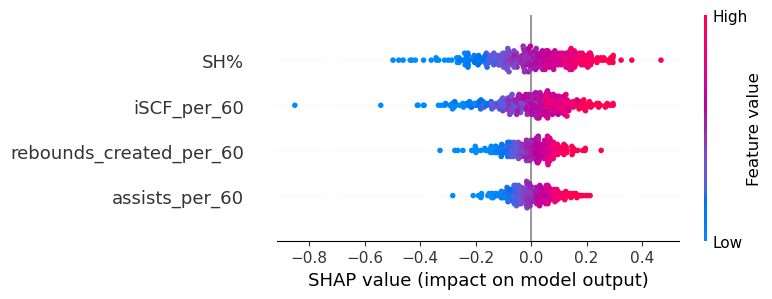

In [85]:
explainer = shap.LinearExplainer(
    ridge_cv_loaded, 
    X_log, 
    feature_perturbation="correlation_dependent" 
)
shap_values = explainer(X_log)

shap_df = pd.DataFrame(
    shap_values.values,     
    columns=X_adjusted.columns,
    index=X_adjusted.index
)

for col in shap_df.columns:
    merged_clutch_goals_prediction[f'shap_{col}'] = shap_df[col]

shap.initjs()

X_log_df = pd.DataFrame(X_log, columns=X_adjusted.columns)

shap.summary_plot(shap_values.values, X_log_df, show=True)

### Final Scatter Plot after Testing
The Actual vs. Predicted shows a well-fitted model for clutch performance. There is a strong linear releationship and homoscedasticity. Some points may deviate from the line of best fit, but this is to be expected due to players naturally overperforming/underpeforming their clutch scores. 

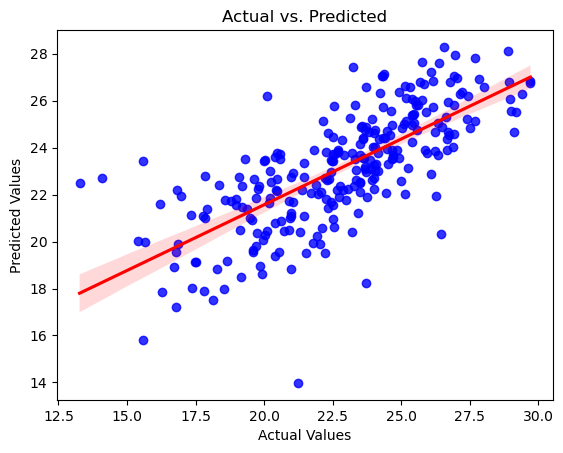

In [87]:
merged_clutch_goals_prediction = merged_clutch_goals_prediction.loc[merged_clutch_goals_prediction['total_goals'] >= 15]
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['actual_clutch_score_adjusted'], y=merged_clutch_goals_prediction['predicted_clutch_score_adjusted'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [88]:
merged_clutch_goals_prediction.to_csv('clutch.csv')

### Temporal Stability
It is important to verify if clutch scoring truly exists. The year-over-year correlations (r = 0.57 for 2021-2022 vs 2022-2023, r = 0.54 for 2022-2023 vs 2023-2024, r = 0.52 for 2023-2024 vs 2024-2026) are all greater than 0.5, which shows clutch scoring is a stable, repeatable skill rather than random variance.

In [140]:
all_seasons = []

for season in range(2015, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby(['playerId', 'season'], as_index = False).agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'goals': 'sum',
            'otGoals': 'sum',
            'teamAbbrevs': 'last'
        }).reset_index(drop = True)

nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D')]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_60'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

Successfully fetched data for season 2015-2016
Successfully fetched data for season 2016-2017
Successfully fetched data for season 2017-2018
Successfully fetched data for season 2018-2019
Successfully fetched data for season 2019-2020
Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024


In [141]:
seasons = ['20152016', '20162017', '20172018', '20182019', '20192020', '20202021', '20212022', '20222023', '20232024']
dataframes_by_season = {}
goals_down_one = pd.DataFrame()
goals_when_tied = pd.DataFrame()
for item in seasons:

    goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={item}&thruseason={item}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
    tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={item}&thruseason={item}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
    total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={item}&thruseason={item}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
    on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={item}&thruseason={item}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

    urls = {
        "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
        "tied": (tied_url, 'goals_when_tied')
    }

    dataframes = {}
    season_data = {}
    for name, (url, new_column_name) in urls.items():
        df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
        col_name = 'goals_down_by_one' if name == 'goals_down_one' else 'goals_when_tied'
        col_toi = 'TOI_Down_One' if name == 'goals_down_one' else 'TOI_Tied'
        df.rename(columns={'Goals': col_name}, inplace=True)
        df.rename(columns={'TOI': col_toi}, inplace=True)
        df['season'] = item
        season_data[name] = df
        time.sleep(2) 

    dataframes_by_season[item] = season_data


for item in seasons:
    goals_down_one = pd.concat([goals_down_one, dataframes_by_season[item]['goals_down_one']])
    goals_when_tied = pd.concat([goals_when_tied, dataframes_by_season[item]['tied']])


goals_down_one = goals_down_one[['TOI_Down_One', 'Player', 'goals_down_by_one', 'season']]
goals_when_tied = goals_when_tied[['TOI_Tied', 'Player', 'goals_when_tied', 'season']]

merged_natural_stat = goals_down_one.merge(goals_when_tied, on = ['Player', 'season'], how = 'left')
merged_natural_stat['season'] = merged_natural_stat['season'].astype(str).apply(lambda x: x[:4] + '-' + x[4:])
merged_natural_stat['clutch_goals'] = merged_natural_stat['goals_down_by_one'] + merged_natural_stat['goals_when_tied']
merged_natural_stat['TOI_Clutch'] = merged_natural_stat['TOI_Down_One'] + merged_natural_stat['TOI_Tied']

natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak", "Zack Bolduc", "Frederic Gaudreau"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak", "Zachary Bolduc", "Freddy Gaudreau"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

merged_clutch_goals_21_24 = nhl_api_df.merge(merged_natural_stat, on = ['Player', 'season'], how = 'left')
merged_clutch_goals_21_24 = merged_clutch_goals_21_24.loc[(merged_clutch_goals_21_24['TOI_Clutch'] >= 150) & (merged_clutch_goals_21_24['goals'] >= 10)]
merged_clutch_goals_21_24 = merged_clutch_goals_21_24.dropna()

#merged_clutch_goals_21_24 = merged_clutch_goals_21_24.loc[merged_clutch_goals_21_24['Player'].isin(merged_clutch_goals_prediction['Player'].values)]


In [142]:
merged_clutch_goals_21_24['clutch_score'] = (
    merged_clutch_goals_21_24['clutch_goals'] / merged_clutch_goals_21_24['TOI_Clutch'] * 60
)

In [143]:
merged_clutch_goals_21_24['clutch_score'] *= 10
merged_clutch_goals_21_24['actual_clutch_score_adjusted'] = np.log(merged_clutch_goals_21_24['clutch_score'] + 1) * 10
merged_clutch_goals_21_24['actual_clutch_score_adjusted'] = merged_clutch_goals_21_24['actual_clutch_score_adjusted'].apply(lambda x: round(x, 2))

In [145]:
merged_clutch_goals_prediction['season'] = '2024-2026'

merged_clutch_goals_21_25_testing = pd.concat([merged_clutch_goals_21_24, merged_clutch_goals_prediction])

merged_clutch_goals_21_25_testing = merged_clutch_goals_21_25_testing.groupby(['Player', 'season'])['clutch_score'].mean().reset_index()

pivot = merged_clutch_goals_21_25_testing.pivot(index='Player', columns='season', values='clutch_score')

seasons = pivot.columns
for i in range(len(seasons)-1):
    valid = pivot[[seasons[i], seasons[i+1]]].dropna()
    r, p = pearsonr(valid[seasons[i]], valid[seasons[i+1]])
    print(f"{seasons[i]} vs {seasons[i+1]}: r = {r:.3f}")

2015-2016 vs 2016-2017: r = 0.339
2016-2017 vs 2017-2018: r = 0.300
2017-2018 vs 2018-2019: r = 0.322
2018-2019 vs 2019-2020: r = 0.336
2019-2020 vs 2020-2021: r = 0.195
2020-2021 vs 2021-2022: r = 0.305
2021-2022 vs 2022-2023: r = 0.437
2022-2023 vs 2023-2024: r = 0.370
2023-2024 vs 2024-2026: r = 0.375


In [146]:
merged_clutch_goals_21_24.to_csv("21_24_clutch.csv")
merged_clutch_goals_prediction.to_csv("clutch.csv")

### Conclusion
Through this project, I hope that I developed a statistically sound goalscoring model. NHL fans, coaches and management can identify forwards who perform well in close game situations and use the regression model to determine if they are underperforming/overperforming expectations. The SHAP analysis should make the model less of a "black box" and enable users to gain more insight into playing styles that influence the predictions. For those more statistically inclined, the prediction intervals can show players who are truly "clutch". The influential points also identify genuinely clutch performers who exceed statistical expectations.

There are potential extensions for this model (e.g. including playoff data, goalie quality adjustments, venue effects). Third-period filtering would be ideal, as trailing with near the end of the game creates maximum pressure. Future versions could incorporate play-by-play timestamps. While the model has limitations, it provides a data-driven framework for evaluating clutch performance.